In [279]:
import scipy.io
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib import cm as colmap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

docs_path = '/Users/luke/Documents/Projects/StrokeNet/Docs/'
parc = 'Sch214'
conbound = 'conbound30/'
results_dir = docs_path+'Results/'+conbound+parc+'/'
data = scipy.io.loadmat(results_dir+'results.mat')

#network info
MNIcoordinates = data['COG']
network_def = data['network_def']
network_order = np.asarray(sorted(range(len(network_def)), key=lambda k: network_def[k]))
network_order.shape = (len(network_order),1)
network_labels = data['network_labels']

In [2]:
network_mappings = {'Visual':1, 'SomatoMotor':2, 'DorstAttn':3, 'SalVentAttn':4, 'Limbic':5, 'Control':6, 'Default':7, 'SubCortical':8}
networks = network_mappings.keys()
reordered_network_affil = network_def[network_order]

# Create a categorical palette to identify the networks
network_palette = ['royalblue','orange','limegreen','olivedrab','orchid','yellow','r','brown']
network_labels = []
for i in range(len(reordered_network_affil)):
    idx = np.int(reordered_network_affil[i]-1)
    network_labels.append(network_palette[idx])

In [208]:
def do_threshold(mat,num_edge=100):
    num_edge = np.int(num_edge/2)
    nRoi = np.shape(mat)[0]
    mat_pos = np.zeros((np.shape(mat)))
    mat_neg = np.zeros((np.shape(mat)))

    # take the upper triangle
    idx = np.triu_indices(nRoi,k=1)
    mat_vec = mat[idx]

    # order it (positive)
    mat_vec = mat[idx]
    cutoff = np.flip(np.argsort(mat_vec))
    mat_vec[cutoff[num_edge::]] = 0
    mat_pos[idx] = mat_vec

    # order it (negative)
    mat_vec = mat[idx]
    cutoff = np.argsort(mat_vec)
    mat_vec[cutoff[num_edge::]] = 0
    mat_neg[idx] = mat_vec

    mat_new = (mat_pos+mat_pos.T)+(mat_neg+mat_neg.T)
    return mat_new

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## Behaviour
### Correlation matrix

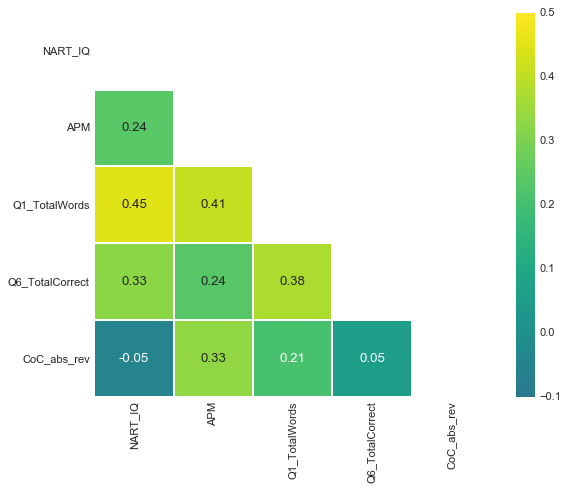

In [209]:
beh_tf = data['behav'][0][0][4]
labels = ['NART_IQ','APM','Q1_TotalWords','Q6_TotalCorrect','CoC_abs_rev']
corr = np.corrcoef(beh_tf.T)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,vmin=-0.1, vmax=0.5, cmap='viridis', center=0,annot=True,fmt='.2f',mask=mask,linewidths=1,xticklabels=labels,yticklabels=labels)
plt.show()

### Data transformations and normality

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


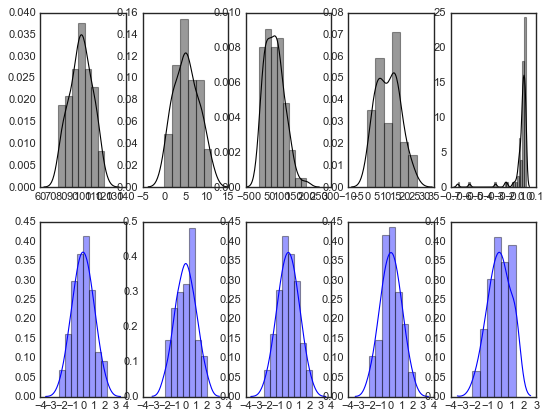

In [210]:
beh = data['behav'][0][0][2]
beh_tf = data['behav'][0][0][4]
num_beh = np.shape(beh_tf)[1]
for measure in range(num_beh):
    plt.subplot(2,num_beh,measure+1)
    sns.distplot(beh[:,measure],color='black')
    plt.subplot(2,num_beh,measure+1+num_beh)
    sns.distplot(beh_tf[:,measure])
plt.show()

## Lesion details
### Voxel plot


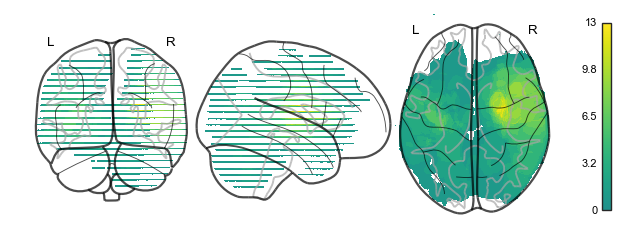

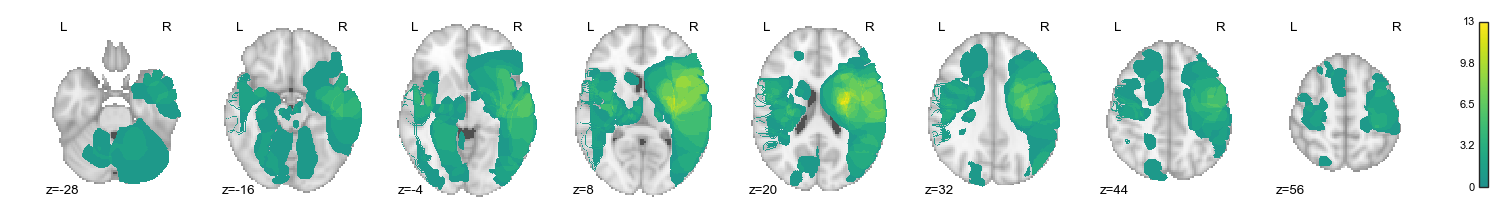

In [219]:
img = '/Users/luke/Documents/Projects/StrokeNet/Docs/Results/voxelwise/LesionOverlap.nii'
plotting.plot_glass_brain(img, threshold=0,colorbar=True,cmap='viridis')
plt.show()

slices = np.arange(-28,62,12)
plotting.plot_stat_map(img, threshold=0,colorbar=True,cmap='viridis',display_mode='z',cut_coords=(slices))
plt.show()

### Connectivity plot

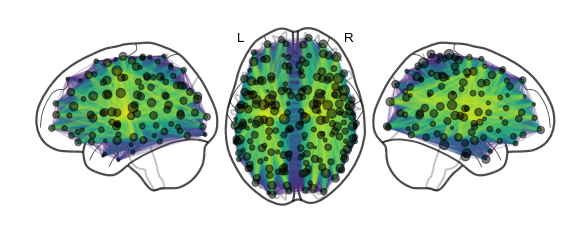

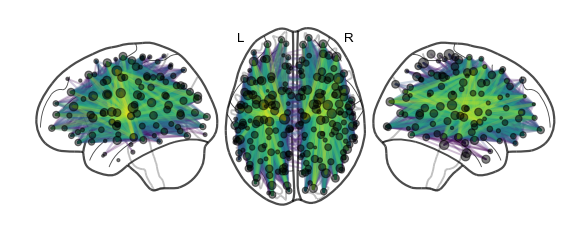

In [213]:
#all connections
cm = data['Cdiff']
cm[cm>0] = 1
cm = np.sum(cm,axis=2)
cm = cm+cm.T
cm_degree = np.sum(abs(cm),axis=1)
cm_degree_plot = (cm_degree / np.max(cm_degree))*100
plotting.plot_connectome(cm, MNIcoordinates,
                         node_size=cm_degree_plot,node_color='black',
                         edge_cmap='viridis',edge_vmin=0,edge_vmax=30,
                         display_mode='lzr',edge_kwargs={'Alpha':0.25},node_kwargs={'Alpha':0.50})
plotting.show()
plt.show()

# at least 10 people
cm[cm<10] = 0
plotting.plot_connectome(cm, MNIcoordinates,
                         node_size=cm_degree_plot,node_color='black',
                         edge_cmap='viridis',edge_vmin=10,edge_vmax=30,
                         display_mode='lzr',edge_kwargs={'Alpha':0.25},node_kwargs={'Alpha':0.50})
plotting.show()
plt.show()

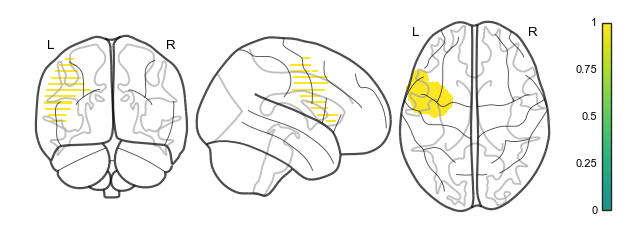

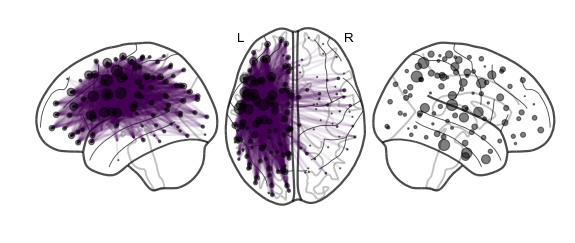

In [236]:
#single sub example
img = '/Users/luke/Documents/Projects/StrokeNet/Data/lesionMaps/3_rNii/rP002_SP.nii'
plotting.plot_glass_brain(img, threshold=0,colorbar=True,cmap='viridis')
cm = data['Cdiff']
cm = cm[:,:,1]>0
cm = cm+cm.T
cm_degree = np.sum(abs(cm),axis=1)
cm_degree_plot = (cm_degree / np.max(cm_degree))*100
plotting.plot_connectome(cm, MNIcoordinates,
                         node_size=cm_degree_plot,node_color='black',
                         edge_cmap='viridis',edge_vmin=1,edge_vmax=2,
                         display_mode='lzr',edge_kwargs={'Alpha':0.10},node_kwargs={'Alpha':0.50})
plt.show()

## MCA results
### Voxel plots

In [ ]:
for comp in range(0,5):
    img = '/Users/luke/Documents/Projects/StrokeNet/Docs/Results/voxelwise/MCA/Component'+str(comp+1)+'.nii'
    plotting.plot_glass_brain(img,colorbar=True,cmap='viridis')
    plt.show()

### Connectivity plots

In [ ]:
components = data['MCA'][0][0][3]
for comp in range(0,5):
    cm = components[:,:,comp]
    cm = cm+cm.T
    cm_degree = np.sum(abs(cm),axis=1)
    cm = do_threshold(cm,num_edge=500)
    cm_degree_plot = (cm_degree / np.max(cm_degree))*75
    plotting.plot_connectome(cm, MNIcoordinates,
                             node_size=cm_degree_plot,node_color='black',
                             edge_cmap='viridis',edge_vmin=-4,edge_vmax=4,
                             display_mode='lzr',edge_kwargs={'Alpha':0.75},node_kwargs={'Alpha':0.50})
    plotting.show()

## CCA Results
### Connectome

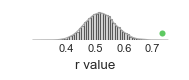

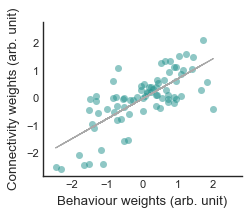

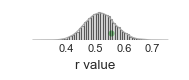

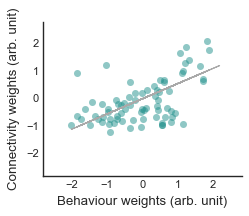

In [277]:
from numpy.polynomial.polynomial import polyfit
plt.style.use('seaborn-white')

U = data['CCA'][0][0][2]
V = data['CCA'][0][0][3]
r = data['CCA'][0][0][4]
r_perms = data['CCA'][0][0][9]

medium_size = 10
large_size = 12

plt.rc('font', size=large_size)          # controls default text sizes
plt.rc('axes', titlesize=large_size)     # fontsize of the axes title
plt.rc('axes', labelsize=large_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=medium_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=medium_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=large_size)    # legend fontsize
plt.rc('figure', titlesize=large_size)  # fontsize of the figure title

for mode in range(0,2):
    ## Permutation plot
    plt.figure(figsize=(2.8,0.5))
    sns.distplot(r_perms,color='darkgray')
    plt.scatter(np.mean(r[:,mode]),2,s=30,alpha = 1,linewidth=0,color=colmap.viridis(0.75))

    remove_border(left=False,bottom=False)
    plt.xlabel("r value")
    #plt.xlim(0.3, 0.85)
    plt.xticks([0.4,0.5,0.6,0.7])
    plt.yticks([])
    plt.show()
    
    ## scatter plot
    x = U[:,:,mode]
    x = np.nanmean(x,axis=1)
    
    y = V[:,:,mode]
    y = np.nanmean(y,axis=1)
    
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    
    plt.figure(figsize=(3.2,2.4))
    plt.scatter(x, y, s=40, alpha = 0.5,linewidth=0,color=cm.viridis(0.5))
    plt.plot(x, b + m * x, '-',linewidth=1,color='darkgray')
    
    #params
    plt.xlim(-2.8, 2.8)
    plt.ylim(-2.8, 2.8)
    plt.xlabel("Behaviour weights (arb. unit)")
    plt.ylabel("Connectivity weights (arb. unit)")
    remove_border()
    plt.show()

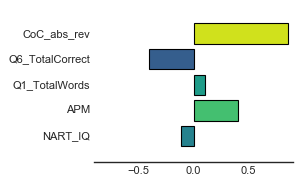

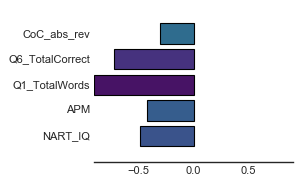

In [241]:
#behaviour loading
behaviour_loading = data['CCA'][0][0][12]
np.shape(behaviour_loading)

for mode in range(0,2):
    x = behaviour_loading[:,mode]
    y_pos = np.arange(len(x))
    colors = colmap.viridis((x+1)/2)

    plt.figure(figsize=(3.2,2.4))
    plt.barh(y_pos, x, align='center',
            color=colors, ecolor=colors)

        #params

    plt.xlim(-0.9, 0.9)
    plt.yticks([0,1,2,3,4,5], labels)
    #plt.xlabel("Behaviour weights (arb. unit)")
    #plt.ylabel("Connectivity weights (arb. unit)")
    remove_border(left=None)
    plt.show()

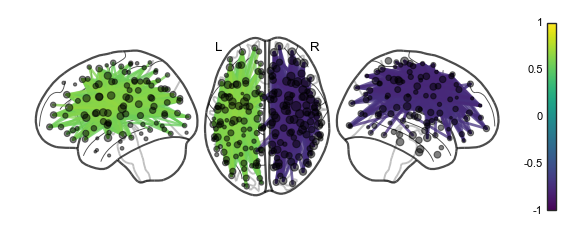

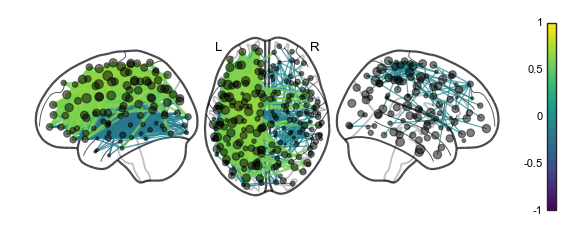

In [324]:
modes = data['CCA'][0][0][11]

for mode in range(0,2):
    cm = modes[:,:,mode] + modes[:,:,mode].T
    cm_degree = np.sum(abs(cm),axis=1)
    cm = do_threshold(cm,num_edge=1000)
    cm_degree_plot = (cm_degree / np.max(cm_degree))*75
    plotting.plot_connectome(cm, MNIcoordinates,
                             node_size=cm_degree_plot,node_color='black',
                             edge_cmap='viridis',edge_vmin=-1,edge_vmax=1,
                             display_mode='lzr',edge_kwargs={'Alpha':0.75},node_kwargs={'Alpha':0.50},colorbar=True)
    plotting.show()

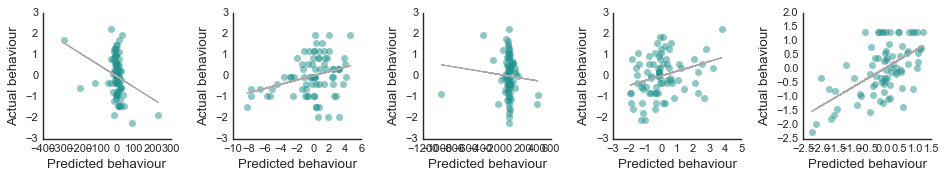

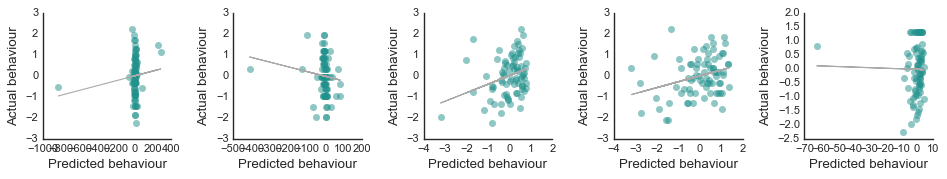

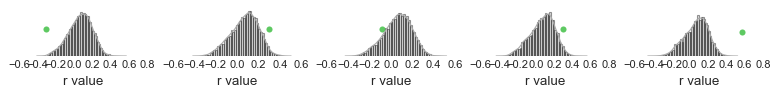

In [278]:
# plot predictions
real_values = data['CCA'][0][0][6]
predicted_values = data['CCA'][0][0][5]

for mode in range(0,2):
    plt.figure(figsize=(12,2.4))
    for behaviour in range(np.shape(real_values)[1]):

        ## scatter plot
        x = predicted_values[:,behaviour,mode]
        y = real_values[:,behaviour]

        # Fit with polyfit
        b, m = polyfit(x, y, 1)

        plt.subplot(1,np.shape(real_values)[1],behaviour+1)
        plt.scatter(x, y, s=40, alpha = 0.5,linewidth=0,color=colmap.viridis(0.5))
        plt.plot(x, b + m * x, '-',linewidth=1,color='darkgray')

        #params
        lim = np.max([np.max(np.abs(x)),np.max(np.abs(y))])
        #plt.xlim(lim*-1,lim)
        #plt.ylim(lim*-1,lim)
        plt.xlabel("Predicted behaviour")
        plt.ylabel("Actual behaviour")
        remove_border()
        plt.tight_layout()
    plt.show()

r_values = data['CCA'][0][0][7]
perm_r_values = data['CCA'][0][0][10]   

plt.figure(figsize=(12,0.75))
for behaviour in range(np.shape(real_values)[1]):
    ## Permutation plot
    plt.subplot(1,np.shape(real_values)[1],behaviour+1)
    sns.distplot(perm_r_values[:,behaviour],color='darkgray')
    plt.scatter(r_values[0,behaviour],2,s=30,alpha = 1,linewidth=0,color=colmap.viridis(0.75))

    remove_border(left=False,bottom=False)
    plt.xlabel("r value")
    #plt.xlim(0.3, 0.85)
    #plt.xticks([0.4,0.5,0.6,0.7,0.8])
    plt.yticks([])
plt.show()

## Interactive plot

In [163]:
modes = data['CCA'][0][0][11]

for mode in range(0,2):
    cm = modes[:,:,mode] + modes[:,:,mode].T
    view = plotting.view_connectome(cm, MNIcoordinates)    
    view.open_in_browser() 

/anaconda3/lib/python3.7/subprocess.py:852: ResourceWarning: subprocess 2104 is still running
  ResourceWarning, source=self)
/anaconda3/lib/python3.7/subprocess.py:852: ResourceWarning: subprocess 2106 is still running
  ResourceWarning, source=self)


## Hubs

In [446]:
def node_plot(node_data,n):
    node_data_rank = np.argsort(node_data*-1,axis=0)
    idx = node_data_rank[0:n]

    #normalise for vis
    node_data = node_data[idx]
    node_data_vis = (node_data-min(node_data))/max((node_data-min(node_data)))

    colors = colmap.viridis(node_data_vis)
    colors_new = colors[:,:,:,0:3]
    colors_new = np.reshape(colors_new,(n,3))

    cm = np.zeros(shape=(n,n))
    coords = np.reshape(MNIcoordinates[idx,:],(n,3))
    plotting.plot_connectome(cm, coords,
                             node_size=75,node_color=colors_new,
                             display_mode='lzr',edge_kwargs={'Alpha':0.75},node_kwargs={'Alpha':.80})
    plt.show()

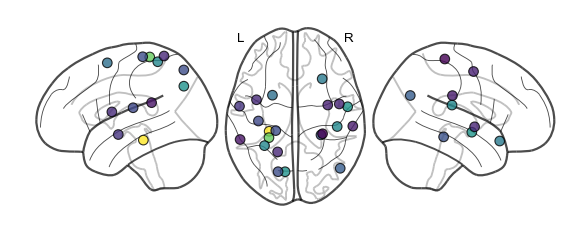

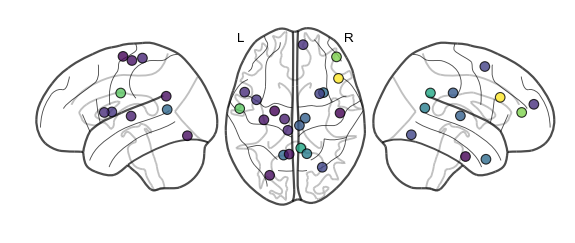

In [447]:
node_data = data['HUB'][0][0][0]

# only display the top N for clarity
n = 21
node_plot(data['HUB'][0][0][0],n)
node_plot(data['HUB'][0][0][1],n)

In [439]:
np.round(214*0.25)

54.0

In [ ]:
for comp in range(0,5):
    cm = components[:,:,comp]
    #cm = cm+cm.T
    cm_ordered = cm[network_order,network_order.T]
    sns.clustermap(cm_ordered,center=0,cmap='viridis',xticklabels=False, yticklabels=False,
                  col_cluster=False,row_cluster=False,row_colors=network_labels,col_colors=network_labels)
    plt.show()

In [ ]:
for mode in range(0,2):
    img = '/Users/luke/Documents/Projects/StrokeNet/Docs/Results/voxelwise/CCA_Mode'+str(mode+1)+'.nii'
    plotting.plot_stat_map(img,colorbar=True,cmap='viridis')
    plt.show()